In [ ]:
1. retrieval
2. generation

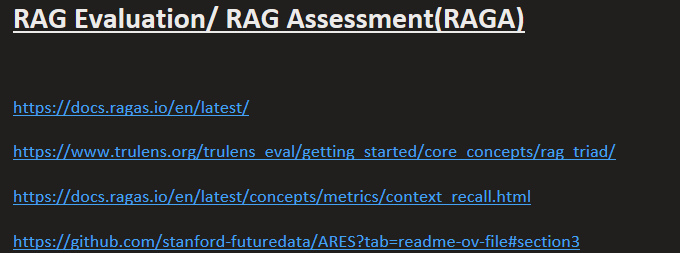

In [ ]:
!pip install langchain openai weaviate-client ragas

In [ ]:
import requests
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

In [ ]:
url="https://raw.githubusercontent.com/langchain-ai/langchain/master/docs/docs/modules/state_of_the_union.txt"

In [ ]:
res = requests.get(url)

In [ ]:
res.text

'Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny. \n\nSix days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. \n\nHe thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. \n\nHe met the Ukrainian people. \n\nFrom President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determination, inspires the world. \n\nGroups of citizens blocking tanks with 

In [ ]:
with open("state_of_the_union.txt", "w") as f:
    f.write(res.text)

In [ ]:
loader=TextLoader("./state_of_the_union.txt")

In [ ]:
documents=loader.load()

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
text_splitter=CharacterTextSplitter(chunk_size=500,chunk_overlap=50)

In [ ]:
chunks=text_splitter.split_documents(documents)

In [ ]:
chunks[2].page_content

'Groups of citizens blocking tanks with their bodies. Everyone from students to retirees teachers turned soldiers defending their homeland. \n\nIn this struggle as President Zelenskyy said in his speech to the European Parliament “Light will win over darkness.” The Ukrainian Ambassador to the United States is here tonight. \n\nLet each of us here tonight in this Chamber send an unmistakable signal to Ukraine and to the world.'

In [ ]:
len(chunks)


90

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Weaviate
import weaviate
from weaviate.embedded import EmbeddedOptions

In [ ]:
from google.colab import userdata
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')

In [ ]:
import os
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

In [ ]:
client=weaviate.Client(
    embedded_options=EmbeddedOptions()
)

Binary /root/.cache/weaviate-embedded did not exist. Downloading binary from https://github.com/weaviate/weaviate/releases/download/v1.23.7/weaviate-v1.23.7-Linux-amd64.tar.gz
Started /root/.cache/weaviate-embedded: process ID 3695


In [ ]:
vectorstore=Weaviate.from_documents(
    client=client,
    documents=chunks,
    embedding=OpenAIEmbeddings(),
    by_text=False

)

In [ ]:
retriever=vectorstore.as_retriever()

In [ ]:
from langchain.chat_models import ChatOpenAI

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

In [ ]:
llm=ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0.2)

In [ ]:
# Define prompt template
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use two sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:
"""

In [ ]:
prompt = ChatPromptTemplate.from_template(template)


In [ ]:
rag_chain=(
    {"context":retriever, "question":RunnablePassthrough()}
          | prompt
          | llm
          | StrOutputParser()
)

In [ ]:
res.text

'Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny. \n\nSix days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. \n\nHe thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. \n\nHe met the Ukrainian people. \n\nFrom President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determination, inspires the world. \n\nGroups of citizens blocking tanks with 

In [ ]:

questions=["what did the President say about Justic Breyer?",
           "What did the President say abou Intel's CEO?",
           "What did the President say about gun violence?"

           ]

In [ ]:
groud_truths=[["The president said that Justice Breyer has dedicated his life to serve the country and thanked him for his service."],
              ["The president said that Pat Gelsinger is ready to increase Intel's investment to $100 billion."],
              ["The president asked Congress to pass proven measures to reduce gun violence."]]

In [ ]:
query

'what did the President say about Justic Breyer?'

In [ ]:
rag_chain.invoke(query)

'The President honored Justice Breyer for his service and mentioned nominating Judge Ketanji Brown Jackson to continue his legacy.'

In [ ]:
answer=[]
context=[]

In [ ]:
for query in questions:
  answer.append(rag_chain.invoke(query))
  context.append([docs.page_content  for docs in retriever.get_relevant_documents(query)])




In [ ]:
answer

['The President honored Justice Breyer for his service and mentioned nominating Judge Ketanji Brown Jackson to continue his legacy.',
 "The President mentioned that Intel's CEO, Pat Gelsinger, is ready to increase their investment from $20 billion to $100 billion, which would be one of the biggest investments in manufacturing in American history.",
 'The President called for Congress to pass measures to reduce gun violence, including universal background checks and banning assault weapons and high-capacity magazines. He also emphasized the need to crack down on gun trafficking and ghost guns.']

In [ ]:
context

[['Tonight, I’d like to honor someone who has dedicated his life to serve this country: Justice Stephen Breyer—an Army veteran, Constitutional scholar, and retiring Justice of the United States Supreme Court. Justice Breyer, thank you for your service. \n\nOne of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court.',
  'And I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal minds, who will continue Justice Breyer’s legacy of excellence.',
  'A former top litigator in private practice. A former federal public defender. And from a family of public school educators and police officers. A consensus builder. Since she’s been nominated, she’s received a broad range of support—from the Fraternal Order of Police to former judges appointed by Democrats and Republicans. \n\nAnd if we are to advance liberty and justice, we need to secure the Borde

In [ ]:
# To dict
data = {
    "question": questions,
    "answer": answer,
    "contexts": context,
    "ground_truths": groud_truths
}




In [ ]:
from datasets import Dataset
dataset=Dataset.from_dict(data)

In [ ]:
!pip install Dataset


In [ ]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

In [ ]:
result=evaluate(
    dataset=dataset,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy
    ]
)

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
result

{'context_precision': 1.0000, 'context_recall': 1.0000, 'faithfulness': 1.0000, 'answer_relevancy': 0.8727}

In [ ]:
df=result.to_pandas()

In [ ]:
df

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,what did the President say about Justic Breyer?,The President honored Justice Breyer for his s...,"[Tonight, I’d like to honor someone who has de...",[The president said that Justice Breyer has de...,The president said that Justice Breyer has ded...,1.0,1.0,1.0,0.830730
1,What did the President say abou Intel's CEO?,"The President mentioned that Intel's CEO, Pat ...",[But that’s just the beginning. \n\nIntel’s CE...,[The president said that Pat Gelsinger is read...,The president said that Pat Gelsinger is ready...,1.0,1.0,1.0,0.879788
2,What did the President say about gun violence?,The President called for Congress to pass meas...,[And I ask Congress to pass proven measures to...,[The president asked Congress to pass proven m...,The president asked Congress to pass proven me...,1.0,1.0,1.0,0.907444


In [ ]:
df.iloc[0,:]

question               what did the President say about Justic Breyer?
answer               The President honored Justice Breyer for his s...
contexts             [Tonight, I’d like to honor someone who has de...
ground_truths        [The president said that Justice Breyer has de...
ground_truth         The president said that Justice Breyer has ded...
context_precision                                                  1.0
context_recall                                                     1.0
faithfulness                                                       1.0
answer_relevancy                                               0.83073
Name: 0, dtype: object

In [ ]:
#data
#this is my actual query
df.iloc[0,:].question

'what did the President say about Justic Breyer?'

In [ ]:
#predicted
#generation of the model
df.iloc[0,:].answer

'The President honored Justice Breyer for his service and mentioned nominating Judge Ketanji Brown Jackson to continue his legacy.'

In [ ]:
#actual
#actual answer(manually we have written this answer)(this could be llm generated)
df.iloc[0,:].ground_truth

'The president said that Justice Breyer has dedicated his life to serve the country and thanked him for his service.'

In [ ]:
#average value
#retrieval result(context)
df.iloc[0,:].contexts[0]

'Tonight, I’d like to honor someone who has dedicated his life to serve this country: Justice Stephen Breyer—an Army veteran, Constitutional scholar, and retiring Justice of the United States Supreme Court. Justice Breyer, thank you for your service. \n\nOne of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court.'

In [ ]:
context_precision                                                  1.0
context_recall                                                     1.0
faithfulness                                                       1.0
answer_relevancy                                               0.83073

In [ ]:
raga:https://docs.ragas.io/en/latest/concepts/metrics/context_recall.html
TrueLence:https://www.trulens.org/trulens_eval/getting_started/core_concepts/rag_triad/
ares:https://github.com/stanford-futuredata/ARES?tab=readme-ov-file#section3

In [ ]:
#rouge summrization
#bleu translation

In [ ]:
from datasets import Dataset
from ragas.metrics import answer_similarity
from ragas import evaluate


data_samples = {
    'question': ['When was the first super bowl?', 'Who won the most super bowls?'],
    'answer': ['The first superbowl was held on Jan 15, 1967', 'The most super bowls have been won by The New England Patriots'],
    'ground_truth': ['The first superbowl was held on January 15, 1967', 'The New England Patriots have won the Super Bowl a record six times']
}
dataset = Dataset.from_dict(data_samples)
score = evaluate(dataset,metrics=[answer_similarity])
score.to_pandas()

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

,question,answer,ground_truth,answer_similarity
0,When was the first super bowl?,"The first superbowl was held on Jan 15, 1967","The first superbowl was held on January 15, 1967",0.996378
1,Who won the most super bowls?,The most super bowls have been won by The New ...,The New England Patriots have won the Super Bo...,0.924285


In [ ]:
from datasets import Dataset
from ragas.metrics import faithfulness, answer_correctness
from ragas import evaluate

data_samples = {
    'question': ['When was the first super bowl?', 'Who won the most super bowls?'],
    'answer': ['The first superbowl was held on Jan 15, 1967', 'The most super bowls have been won by The New England Patriots'],
    'ground_truth': ['The first superbowl was held on January 15, 1967', 'The New England Patriots have won the Super Bowl a record six times']
}
dataset = Dataset.from_dict(data_samples)
score = evaluate(dataset,metrics=[answer_correctness])
score.to_pandas()

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

,question,answer,ground_truth,answer_correctness
0,When was the first super bowl?,"The first superbowl was held on Jan 15, 1967","The first superbowl was held on January 15, 1967",0.749095
1,Who won the most super bowls?,The most super bowls have been won by The New ...,The New England Patriots have won the Super Bo...,0.731078
